### With Forest-Type (UCI dataset)

In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
from evclust.utils import plotting, display_results_fuzzy_partition, display_results_evidential
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from evclust.datasets import load_forest

from evclust.ecm import ecm
from evclust.wecm_new_barycenter import wecm
from evclust.fcm.fcm_keller2000 import fcm as fcm_keller2000
from evclust.fcm.fcm_wang2004 import fcm as fcm_wang2004
from evclust.fcm.fcm_frigui2004 import scad1
from evclust.fcm.fcm_frigui2004 import scad2
from evclust.fcm.ifwfcm_xing2014 import fcm as ifwfcm_xing2014
from evclust.fcm.ifwfcm_kd_xing2014 import fcm as ifwfcm_kd_xing2014

Instances 325 - Features 27 - Class 4
   b1  b2  b3   b4  b5   b6   b7  b8  b9  pred_minus_obs_H_b1  ...  \
0  67  51  68  115  69  111  136  31  67                47.70  ...   
1  67  28  51   99  50   97   82  26  59                47.93  ...   
2  63  26  50   95  49   91   81  26  57                53.09  ...   
3  63  42  63   97  66  108  111  28  59                52.41  ...   
4  46  27  50   83  51   90   76  26  56                68.54  ...   

   pred_minus_obs_H_b9  pred_minus_obs_S_b1  pred_minus_obs_S_b2  \
0                -9.17               -18.27                -1.80   
1                -2.25               -20.13                -2.11   
2                -0.44               -17.64                -1.81   
3                -2.34               -20.20                -1.89   
4                 1.25               -18.62                -2.17   

   pred_minus_obs_S_b3  pred_minus_obs_S_b4  pred_minus_obs_S_b5  \
0                -6.32               -20.88                -1.63

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


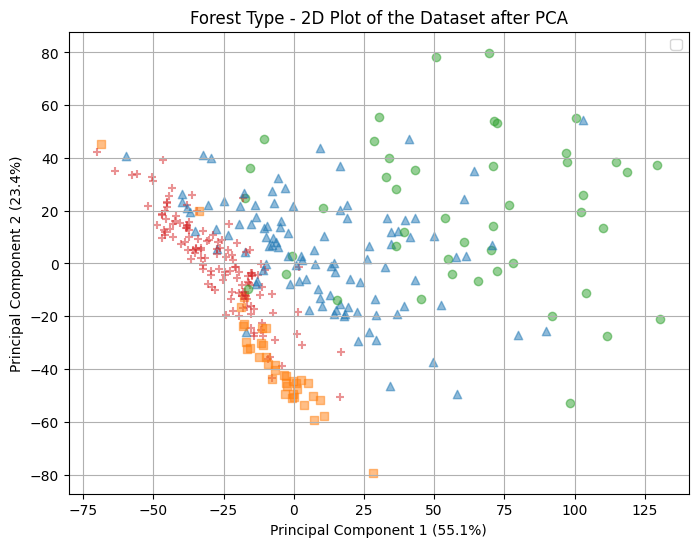

Instances: 325; Features: 27; Clusters: class    4
dtype: int64


In [2]:
### Forest Type dataset
# fetch dataset 
forest_type = load_forest()

X = forest_type.iloc[:, 1:]
y = pd.DataFrame(forest_type.iloc[:, 0])
c = 4

markers = ['^', 's', 'o', '+']
plotting(X, y, "Forest Type", markers=markers)
print(f"Instances: {X.shape[0]}; Features: {X.shape[1]}; Clusters: {y.nunique()}")

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])
# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
ecm_models = np.array([])
for i in range(10):
    model = ecm(x=X, c=c, beta=2, alpha=1, delta=delta, init="None", epsi=1e-6)
    ecm_models = np.append(ecm_models, model)

ecm_models = sorted(ecm_models, key=lambda x: x['crit'])

J values: [25.462434535101913, 25.46243464748555, 25.462434717438402, 25.462434842180592, 25.462434861845452, 25.46243486804957, 25.46243490477392, 25.46243491414406, 25.46243502986757, 25.462479185397402]
ARI values: [0.15580720363965198, 0.15542004886453056, 0.1509313564602044, 0.12849547414868073, 0.1534210625072481, 0.1648250117533687, 0.15820071393846497, 0.14943324750874554, 0.15482246750522513, 0.17954656897455054]
NS values: [1.7173820834921731, 1.7173321621588509, 1.717407592550433, 1.7173433123658028, 1.8609172845351294, 1.7578361711349295, 1.757728489637004, 1.7280689006851109, 1.7280081691875595, 1.7288747229581227]
NMI values: [0.2375291898693312, 0.24285927097259766, 0.23521172501324863, 0.22605873020932551, 0.23674090342880313, 0.2544293395811382, 0.23893848475539659, 0.23453403650275395, 0.24056123493902343, 0.2556750917013594]


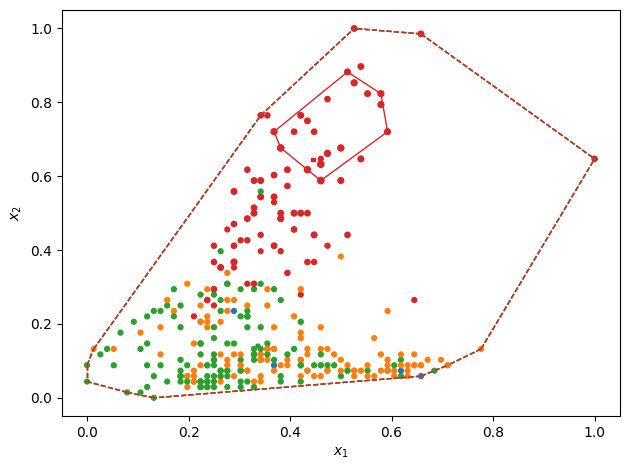

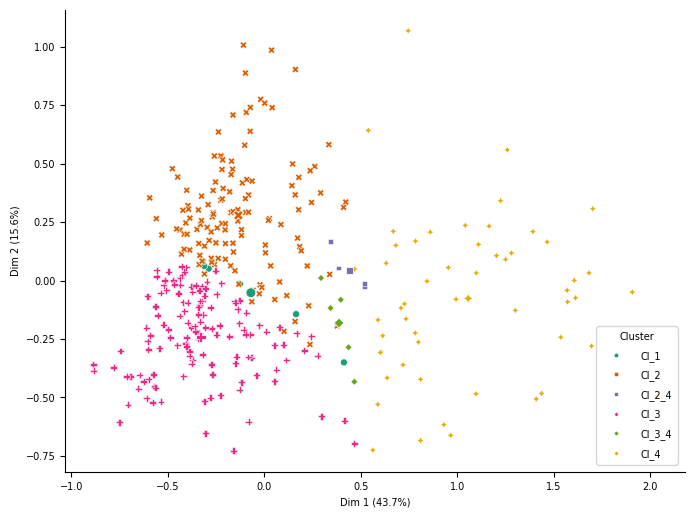

In [4]:
display_results_evidential(X, ecm_models, numeric_labels)

## Weighted ECM (WECM)

In [ ]:
%%capture
wecm_models = np.array([])
d = X.shape[1]
delta = np.sqrt(20)
for i in range(10):
    model = wecm(x=X, c=c, beta=2, alpha=1, delta=delta, init="None", epsilon=1e-3, stopping_factor="center")
    wecm_models = np.append(wecm_models, model)

wecm_models = sorted(wecm_models, key=lambda model: model['crit'])

J values: [0.015158975123315276, 0.015650905517776325, 0.015745126274294613, 0.016968767676679743, 0.017057211981558268, 0.017700723962211406, 0.019828058702485798, 0.02026077371643282, 0.02134335127733189, 0.02392263802249544]
ARI values: [0.22263125880175644, 0.16635954660433544, 0.15399968249284007, 0.15956554905453052, 0.16319570388572477, 0.18840252833106783, 0.1366832211580517, 0.24430707417281555, 0.12702033519912365, 0.1690042787846317]
NS values: [1.5134503825988024, 0.950718629524264, 1.3532172236293363, 1.1578901735376443, 2.451307768813857, 2.3611470412614555, 1.41458842613805, 1.6984714495509, 1.6046693147572724, 1.8317762094509082]
NMI values: [0.21074212014973467, 0.24714200046369908, 0.2501738655394847, 0.2507216129539593, 0.17016095798872832, 0.27934065700595173, 0.21993222760049128, 0.3087206960544102, 0.26199039028133325, 0.26883009513000944]


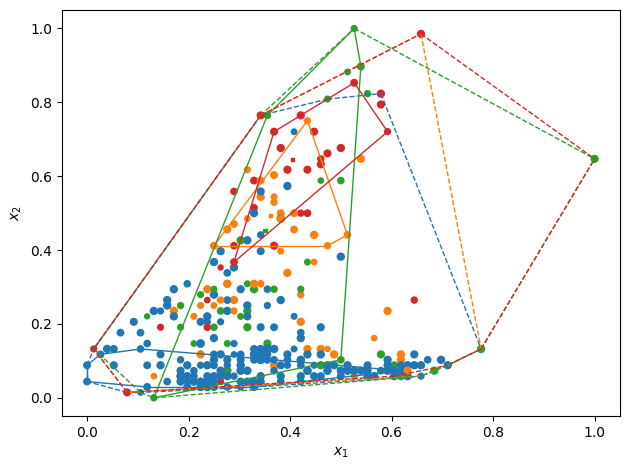

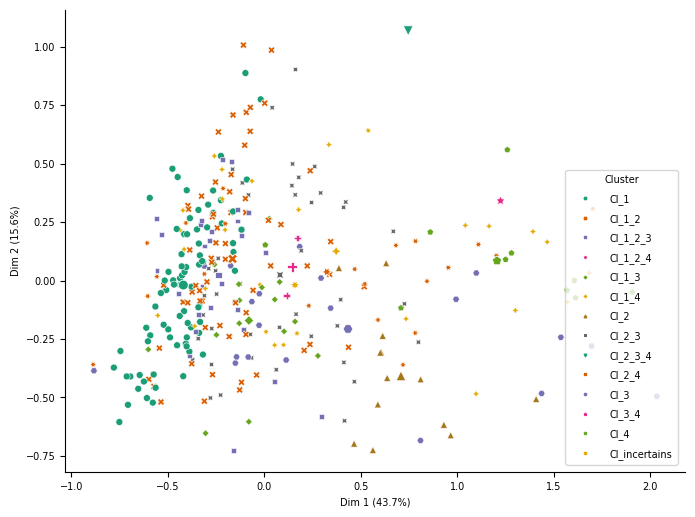

In [4]:
display_results_evidential(X, wecm_models, numeric_labels)

# Weighted FCM - Keller et al. 2000

In [7]:
%%capture
keller_models = np.array([])
# w0 = np.ones((c, X.shape[1])) / X.shape[1]
for i in range(10):
    model = fcm_keller2000(X, c=c, verbose=True, init="None", epsilon=1e-6)
    keller_models = np.append(keller_models, model)
keller_models = sorted(keller_models, key=lambda model: model['obj_func'])

J values: [0.03575318383263404, 0.03575326242207337, 0.03575328643117541, 0.035753488579765715, 0.03575349668015368, 0.035753855639383256, 0.035753928617631874, 0.035753998955919464, 0.035754110750691126, 0.03575413023176239]
ARI values: [0.15440345078587409, 0.15440345078587409, 0.15440345078587409, 0.15676255261151378, 0.15440345078587409, 0.15440345078587409, 0.1573781762401839, 0.15923237714764624, 0.1573781762401839, 0.1598477254601324]
NMI values: [0.24032491431975775, 0.24032491431975772, 0.24032491431975775, 0.24195634411628592, 0.24032491431975775, 0.24032491431975775, 0.24658343248591658, 0.24368008285633708, 0.24658343248591663, 0.24830796723611925]


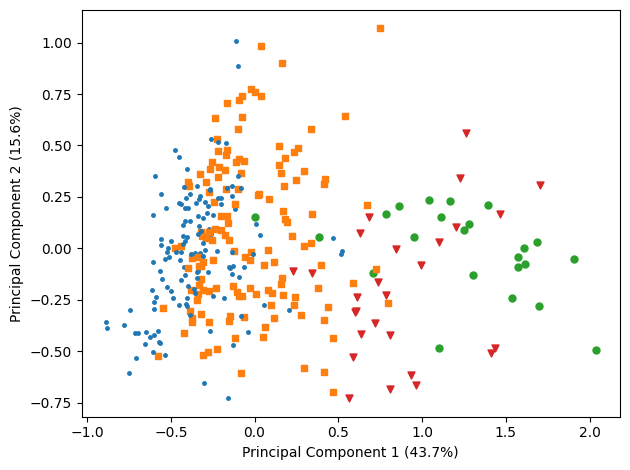

In [8]:
display_results_fuzzy_partition(X, keller_models, numeric_labels)

# Weighted FCM Wang 2004

In [9]:
%%capture
wang_models = np.array([])
for i in range(2):
    model = fcm_wang2004(X, c, w_beta=0.95, verbose=True, init="None")
    wang_models = np.append(wang_models, model)
wang_models = sorted(wang_models, key=lambda model: model['obj_func'])

J values: [0.07696386764545216, 0.07808551941632039]
ARI values: [0.312198613603254, 0.3361496275519645]
NMI values: [0.335807397152493, 0.4012371994784981]


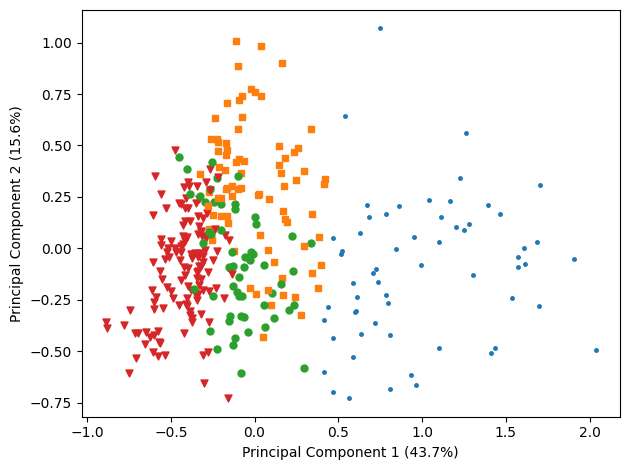

In [10]:
display_results_fuzzy_partition(X, wang_models, numeric_labels)

# SCAD1

In [11]:
%%capture
scad1_models = np.array([])
for i in range(10):
    model = scad1(X, c, verbose=True, K=2, init="None", epsilon=1e-6)
    scad1_models = np.append(scad1_models, model)
scad1_models = sorted(scad1_models, key=lambda model: model['obj_func'])


J values: [5.889693090972962, 5.889693466914437, 5.88969353943647, 5.889693667541554, 5.889693686370051, 5.889693726451824, 5.8896937607030715, 5.889693807203542, 5.889693855941605, 5.889693983163869]
ARI values: [0.2353357193841329, 0.22764859799757156, 0.22303532549988755, 0.2026296992893913, 0.22050974577654495, 0.21950251550930125, 0.23419786831462763, 0.2168735431528638, 0.23419786831462763, 0.22531715159073287]
NMI values: [0.2721614344717459, 0.26608694396275234, 0.27200926106085005, 0.26270867179588236, 0.2676599134210267, 0.27178232141557257, 0.2732918512712539, 0.26728181371022103, 0.2732918512712539, 0.26525514875252465]


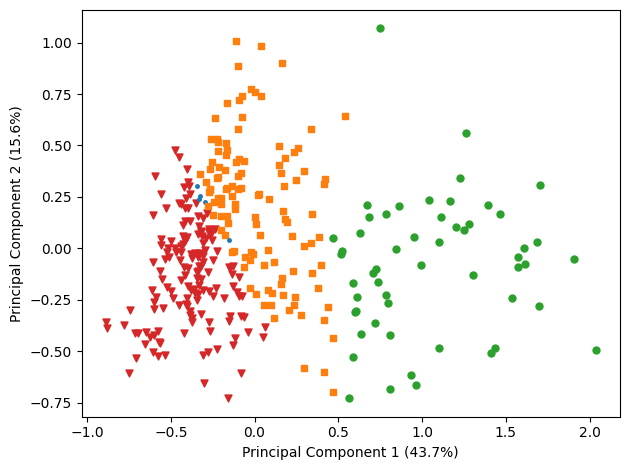

In [12]:
display_results_fuzzy_partition(X, scad1_models, numeric_labels)

# SCAD2

In [13]:
%%capture
scad2_models = np.array([])
for i in range(10):
    model = scad2(X, c, verbose=True, init="None", epsilon=1e-6)
    scad2_models = np.append(scad2_models, model)
scad2_models = sorted(scad2_models, key=lambda model: model['obj_func'])


J values: [0.04702130401656684, 0.04702132230225896, 0.0470214890299582, 0.04702172108524818, 0.047023219108028716, 0.0470262281891141, 0.047038476592611386, 0.04704535143638483, 0.047050946981626464, 0.047052793787617654]
ARI values: [0.37190472388648005, 0.37190472388648005, 0.37190472388648005, 0.3705955964186721, 0.3693862416747059, 0.3693862416747059, 0.35689733986196887, 0.36232351127655815, 0.3674247351903601, 0.3362842505984336]
NMI values: [0.4258244759335785, 0.42582447593357836, 0.4258244759335785, 0.4250495099908695, 0.4243423006379921, 0.4243423006379921, 0.4133563911320182, 0.4196617703271119, 0.4221448297777393, 0.3568673356061816]


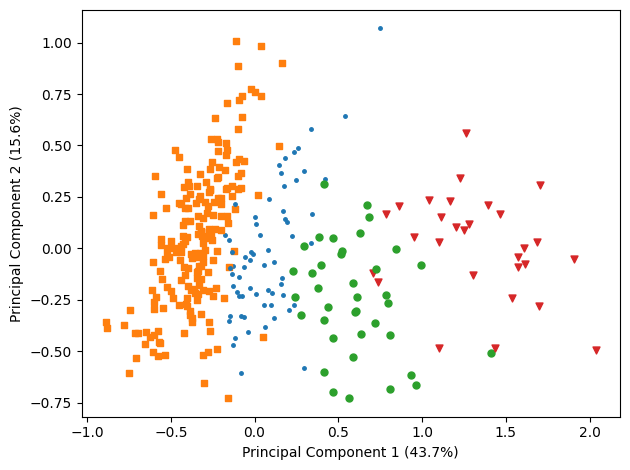

In [14]:
display_results_fuzzy_partition(X, scad2_models, numeric_labels)

# IFWFCM - Xing et al. 2014

In [15]:
%%capture
ifwfcm_models = np.array([])
for i in range(10):
    model = ifwfcm_xing2014(X, c, verbose=True, init="None", epsilon=1e-6)
    ifwfcm_models = np.append(ifwfcm_models, model)
ifwfcm_models = sorted(ifwfcm_models, key=lambda model: model['obj_func'])

J values: [0.06803336306193714, 0.0680334810618421, 0.06803372255012376, 0.06803389231844137, 0.06803400940122396, 0.06803406355665902, 0.06803461337774096, 0.0680346261637184, 0.0680517634444909, 0.06805631413534022]
ARI values: [0.12005953348491004, 0.11572698373766041, 0.11538683357709358, 0.15384382729526147, 0.11683743641770813, 0.11745560799201506, 0.11513765192325957, 0.11557429601434628, 0.1162942741160936, 0.1114744087747192]
NMI values: [0.18192936111145272, 0.17807110489743702, 0.1810403335107343, 0.21688655749577382, 0.17939900022924143, 0.17908573197389324, 0.17706724953059821, 0.17750122205769786, 0.18137002882767872, 0.175978167154398]


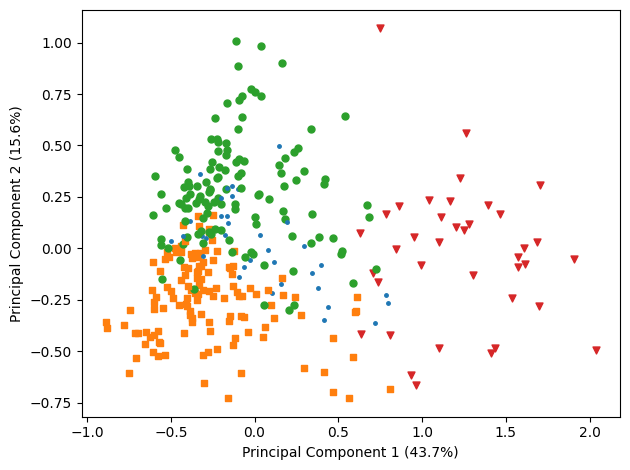

In [16]:
display_results_fuzzy_partition(X, ifwfcm_models, numeric_labels)

# IFWFCM_KD Xing 2014

In [17]:
%%capture
ifwfcm_kd_models = np.array([])
for i in range(10):
    model = ifwfcm_kd_xing2014(X, c, verbose=True, init="None", epsilon=1e-6)
    ifwfcm_kd_models = np.append(ifwfcm_kd_models, model)
ifwfcm_kd_models = sorted(ifwfcm_kd_models, key=lambda model: model['obj_func'])

J values: [1.0123848656870198, 1.0123865593357078, 1.0123935956118164, 1.0123938946623345, 1.0123939295789888, 1.0123939642100923, 1.0123940045410307, 1.0123942265845554, 1.0123943307154417, 1.0124478275251008]
ARI values: [0.11617154467475119, 0.11514899493602566, 0.11798259441975247, 0.11798259441975247, 0.11798259441975247, 0.11798259441975247, 0.11798259441975247, 0.11798259441975247, 0.11798259441975247, 0.12154955140763467]
NMI values: [0.179112932438637, 0.17919942066691918, 0.18024282003384703, 0.18024282003384703, 0.18024282003384703, 0.18024282003384703, 0.18024282003384703, 0.18024282003384703, 0.18024282003384703, 0.1828273193155436]


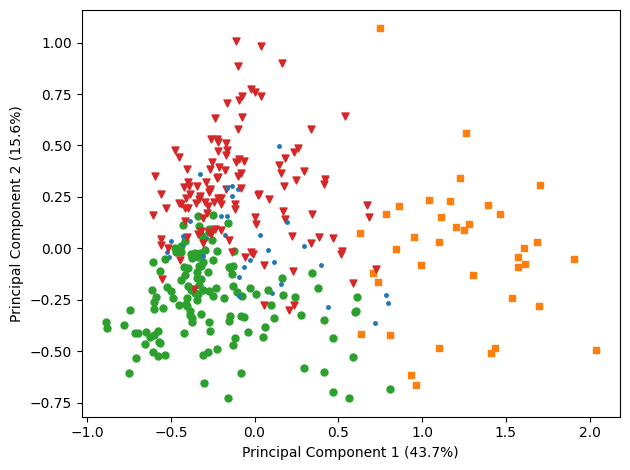

In [18]:
display_results_fuzzy_partition(X, ifwfcm_kd_models, numeric_labels)